In [11]:
import csv
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [12]:
# load the following to files from DETECTED_SGG_DIR
custom_prediction = json.load(open('../datasets/custom-data/pai-data/checkpoints/motifs/custom_prediction.json'))
custom_data_info = json.load(open('../datasets/custom-data/pai-data/checkpoints/motifs/custom_data_info.json'))

In [13]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None, save_image=False):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)

    save_path = img_path.split('/')[-1]

    
    if save_image == True:
        pic.save(f'./sgg-output-images/motifs-tde/{save_path}', 'JPEG' )

    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)



def extract_scene_graph_csv(custom_prediction, custom_data_info, box_topk=15, rel_topk=15, output_csv='output.csv'):
    # Initialize list to store data for sorting
    data = []

    ind_to_classes = custom_data_info['ind_to_classes']
    ind_to_predicates = custom_data_info['ind_to_predicates']
    idx_to_files = custom_data_info['idx_to_files']
    
    for image_idx_str in custom_prediction.keys():
        image_idx = int(image_idx_str)
        image_path = idx_to_files[image_idx]  # Use integer index since idx_to_files is a list
        # Extract image_name from image_path
        image_name = image_path.split('/')[-1][:-4]  # Remove extension
        # Extract the number at the end of the image name
        last_number = int(image_name.split('_')[-1])
        # Now process the predictions for this image
        boxes = custom_prediction[image_idx_str]['bbox'][:box_topk]
        box_labels = custom_prediction[image_idx_str]['bbox_labels'][:box_topk]
        # Map box labels from indices to class names
        box_labels = [ind_to_classes[label] for label in box_labels]  # Use integer keys
        # All relations
        all_rel_labels = custom_prediction[image_idx_str]['rel_labels']
        all_rel_scores = custom_prediction[image_idx_str]['rel_scores']
        all_rel_pairs = custom_prediction[image_idx_str]['rel_pairs']
        # Build the list of relation tuples
        rel_label_tuple = []
        for i in range(len(all_rel_pairs)):
            subj_idx = all_rel_pairs[i][0]
            obj_idx = all_rel_pairs[i][1]
            if subj_idx < box_topk and obj_idx < box_topk:
                subj_label = box_labels[subj_idx]
                pred_label = ind_to_predicates[all_rel_labels[i]]  # Use integer key
                obj_label = box_labels[obj_idx]
                rel_label_tuple.append((subj_label, pred_label, obj_label))
        # Keep only the top rel_topk relations
        rel_label_tuple = rel_label_tuple[:rel_topk]
        # Convert the list of tuples to a string representation using str()
        scene_graph_str = str(rel_label_tuple)
        # Collect data for sorting
        data.append((last_number, image_name, scene_graph_str))
    
    # Now sort the data based on last_number
    data.sort(key=lambda x: x[0])
    
    # Now write to CSV
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image_name', 'scene_graph'])
        for _, image_name, scene_graph_str in data:
            writer.writerow([image_name, scene_graph_str])



In [14]:
# parameters
# image_idx = 1, 29, 26, 24, 22,
image_idx = 15
box_topk = 20 # select top k bounding boxes
rel_topk = 20 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']

20170101_1525_25
img_rel_label =  [('man', 'on', 'elephant'), ('person', 'on', 'elephant'), ('man', 'wearing', 'pant'), ('man', 'wearing', 'short'), ('man', 'wearing', 'shirt'), ('man', 'wearing', 'short'), ('man', 'wearing', 'pant'), ('man', 'wearing', 'shirt'), ('person', 'wearing', 'pant'), ('person', 'wearing', 'short'), ('man', 'wearing', 'short'), ('man', 'on', 'elephant'), ('man', 'wearing', 'pant'), ('branch', 'on', 'tree'), ('man', 'has', 'arm'), ('person', 'wearing', 'pant'), ('person', 'wearing', 'short'), ('branch', 'on', 'tree'), ('man', 'wearing', 'short'), ('man', 'has', 'arm')]


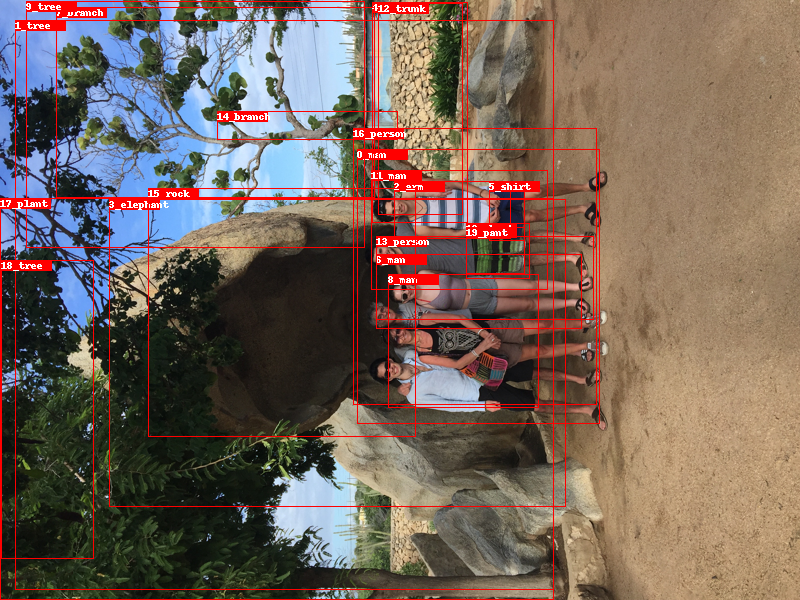

**************************************************
box_labels 0: man; score: 0.7557539939880371
box_labels 1: tree; score: 0.6340909004211426
box_labels 2: arm; score: 0.1725342869758606
box_labels 3: elephant; score: 0.14199908077716827
box_labels 4: tree; score: 0.11396084725856781
box_labels 5: shirt; score: 0.11022311449050903
box_labels 6: man; score: 0.09894213080406189
box_labels 7: branch; score: 0.08979678153991699
box_labels 8: man; score: 0.08670713007450104
box_labels 9: tree; score: 0.08373194187879562
box_labels 10: short; score: 0.08006688207387924
box_labels 11: man; score: 0.06764872372150421
box_labels 12: trunk; score: 0.06433937698602676
box_labels 13: person; score: 0.06136705353856087
box_labels 14: branch; score: 0.05443553999066353
box_labels 15: rock; score: 0.054077181965112686
box_labels 16: person; score: 0.04862044379115105
box_labels 17: plant; score: 0.04158727824687958
box_labels 18: tree; score: 0.04054776579141617
box_labels 19: pant; score: 0.03999325

In [15]:
image_path = custom_data_info['idx_to_files'][image_idx]
print(image_path.split('/')[-1][:-4])
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]


# storing in predicted relations in tuple form
rel_label_tuple = []
rel_score_tuple = []

for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_score_tuple.append(all_rel_scores[i])
        # Modify the label formatting here to tuple format
        label = (box_labels[all_rel_pairs[i][0]], ind_to_predicates[all_rel_labels[i]], box_labels[all_rel_pairs[i][1]])
        rel_label_tuple.append(label)

rel_label_tuple = rel_label_tuple[:rel_topk]
rel_score_tuple = rel_score_tuple[:rel_topk]



img_rel_label = rel_label_tuple
print("img_rel_label = ", img_rel_label)





# original code from sg-benchmark (produce triplets with confidence levels)
rel_labels = []
rel_scores = []

for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores, save_image=True)



extract_scene_graph_csv(custom_prediction, custom_data_info, box_topk=20, rel_topk=20, output_csv='motifs-boxtopk20-reltopk20-output.csv')
